In [8]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Configure plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 8)

In [9]:
# Load the dataset
df = pd.read_csv('train.csv')
print(f"Dataset loaded successfully. Shape: {df.shape}")

# Display the first few rows
df.head()

Dataset loaded successfully. Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Missing values:
GrLivArea     0
GarageArea    0
dtype: int64


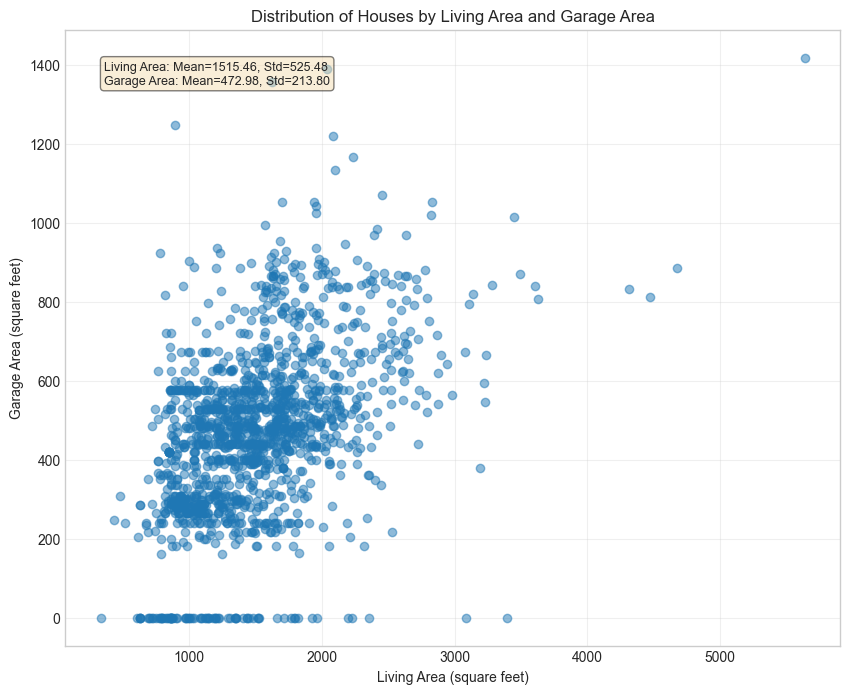

In [10]:
# Extract the two variables in consideration
X = df[['GrLivArea', 'GarageArea']]

# Check for missing values
print("Missing values:")
print(X.isnull().sum())

# Fill missing values if any (using mean)
X = X.fillna(X.mean())

# Visualize the 2D distribution
plt.figure(figsize=(10, 8))
plt.scatter(X['GrLivArea'], X['GarageArea'], alpha=0.5)
plt.title('Distribution of Houses by Living Area and Garage Area')
plt.xlabel('Living Area (square feet)')
plt.ylabel('Garage Area (square feet)')
plt.grid(True, alpha=0.3)

# Add statistics to the plot
textstr = '\n'.join((
    f'Living Area: Mean={X["GrLivArea"].mean():.2f}, Std={X["GrLivArea"].std():.2f}',
    f'Garage Area: Mean={X["GarageArea"].mean():.2f}, Std={X["GarageArea"].std():.2f}'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='top', bbox=props)

plt.show()

K=2, Silhouette Score=0.401, Inertia=1648.441
K=3, Silhouette Score=0.359, Inertia=1206.768
K=4, Silhouette Score=0.344, Inertia=970.440
K=5, Silhouette Score=0.365, Inertia=777.669
K=6, Silhouette Score=0.376, Inertia=669.724
K=7, Silhouette Score=0.380, Inertia=583.739
K=8, Silhouette Score=0.384, Inertia=511.276
K=9, Silhouette Score=0.373, Inertia=449.221
K=10, Silhouette Score=0.374, Inertia=405.419


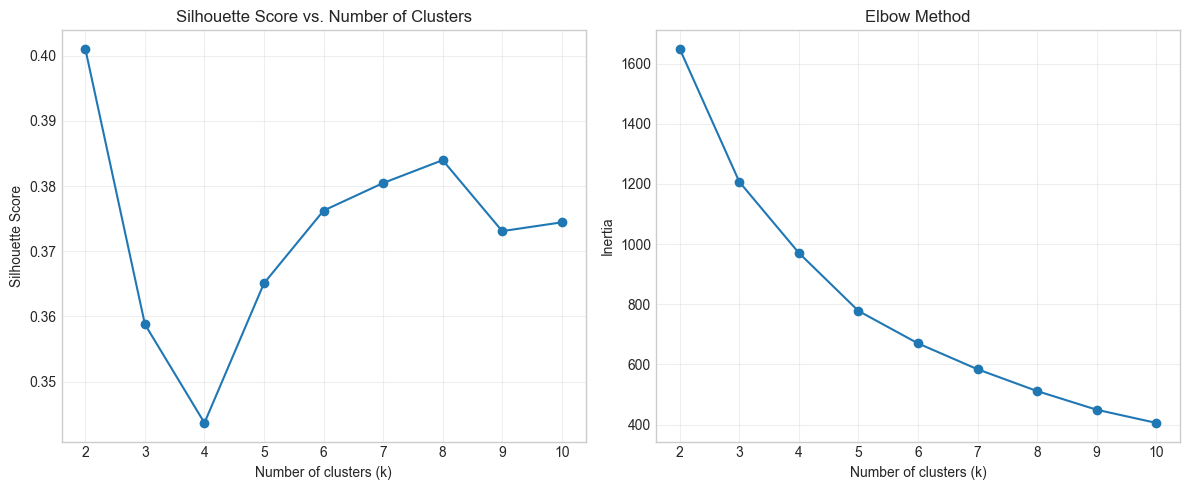

Optimal number of clusters based on silhouette score: 2


In [11]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculate silhouette scores for different k values
sil_scores = []
inertias = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    
    # Calculate silhouette score
    sil_score = silhouette_score(X_scaled, labels)
    sil_scores.append(sil_score)
    
    # Calculate inertia (sum of squared distances to centroids)
    inertias.append(kmeans.inertia_)
    
    print(f"K={k}, Silhouette Score={sil_score:.3f}, Inertia={kmeans.inertia_:.3f}")

# Plot silhouette scores and elbow curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, sil_scores, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_values, inertias, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k
optimal_k = k_values[np.argmax(sil_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

K-Means Cluster Distribution:
Cluster 0: 918 points (62.88%)
  Centroid: GrLivArea=1236.86, GarageArea=369.83
Cluster 1: 542 points (37.12%)
  Centroid: GrLivArea=1987.33, GarageArea=647.69


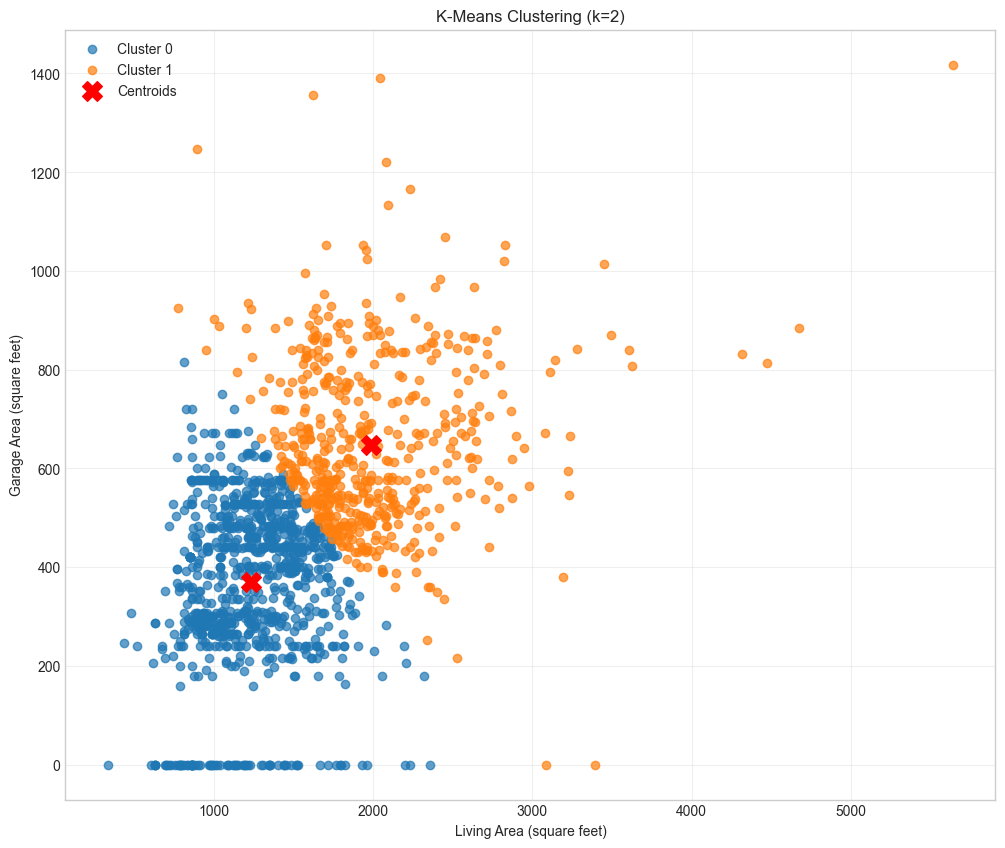

In [12]:
# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Add cluster labels to the data
X_kmeans = X.copy()
X_kmeans['Cluster'] = kmeans.labels_

# Count points in each cluster
cluster_counts = X_kmeans['Cluster'].value_counts().sort_index()
cluster_percentages = 100 * cluster_counts / len(X_kmeans)

print("K-Means Cluster Distribution:")
for i, (count, percentage) in enumerate(zip(cluster_counts, cluster_percentages)):
    print(f"Cluster {i}: {count} points ({percentage:.2f}%)")
    
    # Get centroids in original scale
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    print(f"  Centroid: GrLivArea={centroids[i, 0]:.2f}, GarageArea={centroids[i, 1]:.2f}")

# Plot the clusters
plt.figure(figsize=(12, 10))
for i in range(optimal_k):
    cluster_data = X_kmeans[X_kmeans['Cluster'] == i]
    plt.scatter(cluster_data['GrLivArea'], cluster_data['GarageArea'], 
                label=f'Cluster {i}', alpha=0.7)

# Add centroids
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, marker='X', c='red', label='Centroids')

plt.title(f'K-Means Clustering (k={optimal_k})')
plt.xlabel('Living Area (square feet)')
plt.ylabel('Garage Area (square feet)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
# Step 5: DBSCAN Clustering
def perform_dbscan(X, scaler):
    # X_scaled should already be scaled from K-means
    X_scaled = scaler.transform(X)

    # Try different epsilon values
    eps_values = np.arange(0.1, 1.0, 0.1)
    min_samples = 4  # Typically 2*dimensions for 2D data

    results = []
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_scaled)

        # Calculate silhouette score if we have at least 2 clusters (excluding noise)
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

        if n_clusters >= 2:
            # For silhouette score, remove noise points
            mask = clusters != -1
            if np.sum(mask) >= 2:  # Need at least 2 points
                sil_score = silhouette_score(X_scaled[mask], clusters[mask])
            else:
                sil_score = 0
        else:
            sil_score = 0

        # Count noise points
        n_noise = list(clusters).count(-1)

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_percent': 100 * n_noise / len(X),
            'silhouette': sil_score
        })

        print(
            f"eps={eps:.1f}, clusters={n_clusters}, noise={n_noise} ({100 * n_noise / len(X):.2f}%), silhouette={sil_score:.3f}")

    # Plot performance metrics
    plt.figure(figsize=(12, 10))

    # Plot silhouette scores
    plt.subplot(3, 1, 1)
    plt.plot([r['eps'] for r in results], [r['silhouette'] for r in results], 'o-')
    plt.xlabel('Epsilon')
    plt.ylabel('Silhouette Score')
    plt.title('DBSCAN: Silhouette Score vs. Epsilon')
    plt.grid(True, alpha=0.3)

    # Plot number of clusters
    plt.subplot(3, 1, 2)
    plt.plot([r['eps'] for r in results], [r['n_clusters'] for r in results], 'o-')
    plt.xlabel('Epsilon')
    plt.ylabel('Number of Clusters')
    plt.title('DBSCAN: Number of Clusters vs. Epsilon')
    plt.grid(True, alpha=0.3)

    # Plot percentage of noise points
    plt.subplot(3, 1, 3)
    plt.plot([r['eps'] for r in results], [r['noise_percent'] for r in results], 'o-')
    plt.xlabel('Epsilon')
    plt.ylabel('Noise Points (%)')
    plt.title('DBSCAN: Percentage of Noise Points vs. Epsilon')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('dbscan_performance.png')
    plt.close()

    # Find optimal epsilon based on silhouette score and reasonable noise percentage
    valid_results = [r for r in results if r['n_clusters'] >= 2 and r['noise_percent'] < 50]
    if valid_results:
        optimal_result = max(valid_results, key=lambda r: r['silhouette'])
        optimal_eps = optimal_result['eps']
    else:
        # Fallback
        optimal_eps = 0.4  # Common default

    print(f"Optimal epsilon based on silhouette score: {optimal_eps}")

    # Apply DBSCAN with optimal parameters
    dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X_scaled)

    # Add cluster labels to the data
    X_dbscan = X.copy()
    X_dbscan['Cluster'] = clusters

    # Plot the clusters
    plt.figure(figsize=(12, 10))

    # Create a colormap with noise points in black
    unique_clusters = np.unique(clusters)
    is_noise = clusters == -1
    cluster_colors = np.zeros(clusters.shape, dtype=np.int32)
    cluster_colors[~is_noise] = clusters[~is_noise] + 1

    # Scatter plot with cluster colors
    plt.scatter(X['GrLivArea'][~is_noise], X['GarageArea'][~is_noise],
                c=clusters[~is_noise], cmap='viridis', s=50, alpha=0.7)

    # Plot noise points in black
    plt.scatter(X['GrLivArea'][is_noise], X['GarageArea'][is_noise],
                c='black', s=15, alpha=0.5, label='Noise')

    plt.title(f'DBSCAN Clustering (eps={optimal_eps}, min_samples={min_samples})')
    plt.xlabel('Living Area (square feet)')
    plt.ylabel('Garage Area (square feet)')
    plt.colorbar(label='Cluster')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('dbscan_clusters.png')
    plt.close()

    # Count points in each cluster
    cluster_counts = pd.Series(clusters).value_counts().sort_index()
    cluster_percentages = 100 * cluster_counts / len(X)

    print("\nDBSCAN Cluster Distribution:")
    for cluster, (count, percentage) in enumerate(zip(cluster_counts, cluster_percentages)):
        label = "Noise" if cluster == -1 else f"Cluster {cluster}"
        print(f"{label}: {count} points ({percentage:.2f}%)")

    return optimal_eps, dbscan, X_dbscan

eps=0.1, clusters=37, noise=282 (19.32%), silhouette=-0.046
eps=0.2, clusters=6, noise=79 (5.41%), silhouette=0.190
eps=0.3, clusters=3, noise=46 (3.15%), silhouette=0.241
eps=0.4, clusters=2, noise=34 (2.33%), silhouette=0.410
eps=0.5, clusters=3, noise=13 (0.89%), silhouette=0.345
eps=0.6, clusters=2, noise=11 (0.75%), silhouette=0.403
eps=0.7, clusters=2, noise=10 (0.68%), silhouette=0.402
eps=0.8, clusters=1, noise=8 (0.55%), silhouette=0.000
eps=0.9, clusters=1, noise=8 (0.55%), silhouette=0.000


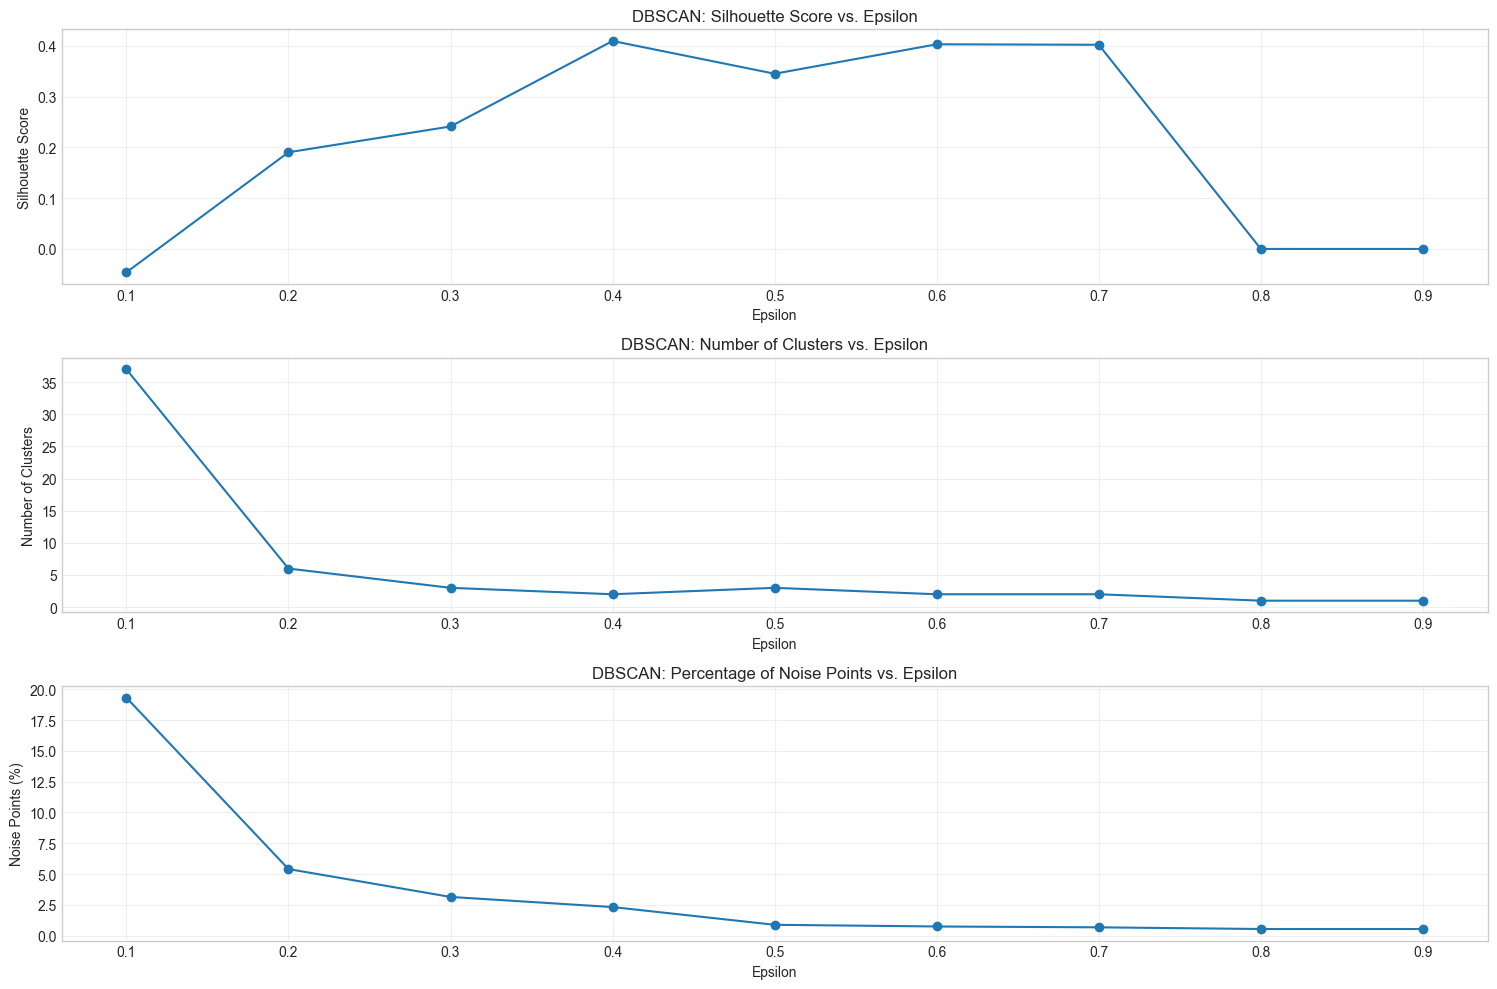

Optimal epsilon based on silhouette score: 0.4


In [14]:
# Try different epsilon values
eps_values = np.arange(0.1, 1.0, 0.1)
min_samples = 4  # Typically 2*dimensions for 2D data

results = []
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X_scaled)
    
    # Calculate silhouette score if we have at least 2 clusters (excluding noise)
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    
    if n_clusters >= 2:
        # For silhouette score, remove noise points
        mask = clusters != -1
        if np.sum(mask) >= 2:  # Need at least 2 points
            sil_score = silhouette_score(X_scaled[mask], clusters[mask])
        else:
            sil_score = 0
    else:
        sil_score = 0
        
    # Count noise points
    n_noise = list(clusters).count(-1)
    
    results.append({
        'eps': eps,
        'min_samples': min_samples,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_percent': 100 * n_noise / len(X),
        'silhouette': sil_score
    })
    
    print(f"eps={eps:.1f}, clusters={n_clusters}, noise={n_noise} ({100*n_noise/len(X):.2f}%), silhouette={sil_score:.3f}")

# Plot performance metrics
plt.figure(figsize=(15, 10))

# Plot silhouette scores
plt.subplot(3, 1, 1)
plt.plot([r['eps'] for r in results], [r['silhouette'] for r in results], 'o-')
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.title('DBSCAN: Silhouette Score vs. Epsilon')
plt.grid(True, alpha=0.3)

# Plot number of clusters
plt.subplot(3, 1, 2)
plt.plot([r['eps'] for r in results], [r['n_clusters'] for r in results], 'o-')
plt.xlabel('Epsilon')
plt.ylabel('Number of Clusters')
plt.title('DBSCAN: Number of Clusters vs. Epsilon')
plt.grid(True, alpha=0.3)

# Plot percentage of noise points
plt.subplot(3, 1, 3)
plt.plot([r['eps'] for r in results], [r['noise_percent'] for r in results], 'o-')
plt.xlabel('Epsilon')
plt.ylabel('Noise Points (%)')
plt.title('DBSCAN: Percentage of Noise Points vs. Epsilon')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal epsilon based on silhouette score and reasonable noise percentage
valid_results = [r for r in results if r['n_clusters'] >= 2 and r['noise_percent'] < 50]
if valid_results:
    optimal_result = max(valid_results, key=lambda r: r['silhouette'])
    optimal_eps = optimal_result['eps']
else:
    # Fallback
    optimal_eps = 0.4  # Common default

print(f"Optimal epsilon based on silhouette score: {optimal_eps}")


DBSCAN Cluster Distribution:
Noise: 34 points (2.33%)
Cluster 0: 1351 points (92.53%)
Cluster 1: 75 points (5.14%)


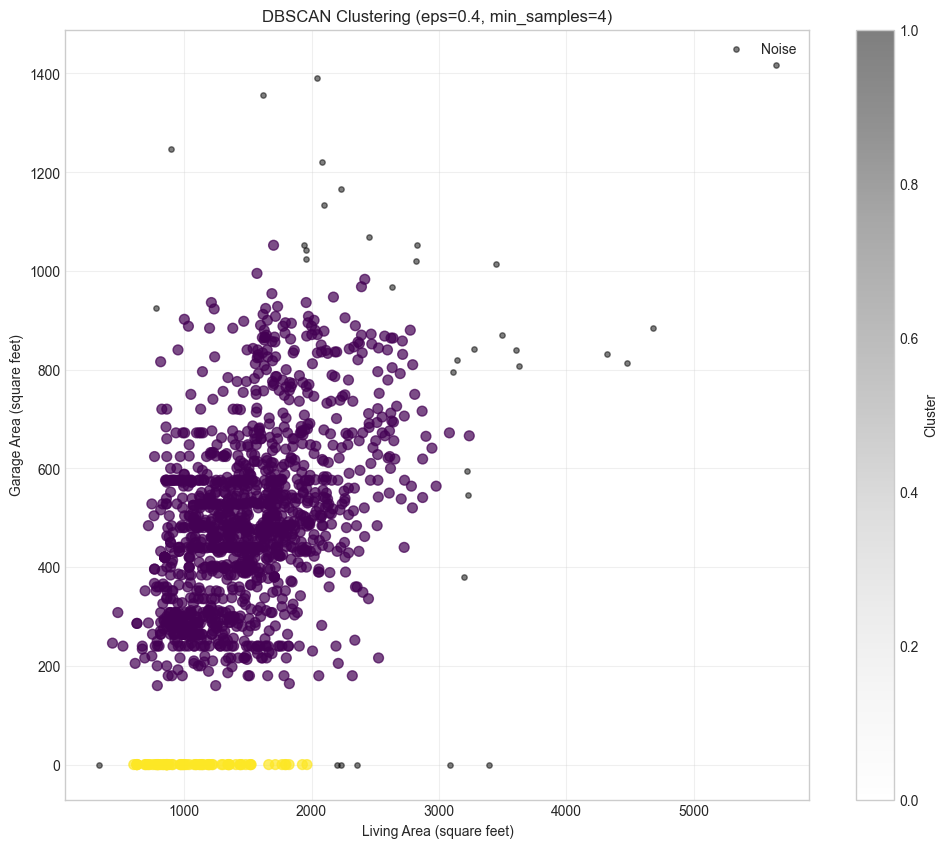

In [15]:
# Apply DBSCAN with optimal parameters
optimal_eps = 0.4  # Use the optimal value from previous cell
min_samples = 4

dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X_scaled)

# Add cluster labels to the data
X_dbscan = X.copy()
X_dbscan['Cluster'] = clusters

# Count points in each cluster
unique_clusters = np.unique(clusters)
print("\nDBSCAN Cluster Distribution:")
for cluster in unique_clusters:
    count = (clusters == cluster).sum()
    percentage = 100 * count / len(X)
    if cluster == -1:
        print(f"Noise: {count} points ({percentage:.2f}%)")
    else:
        print(f"Cluster {cluster}: {count} points ({percentage:.2f}%)")

# Plot the clusters
plt.figure(figsize=(12, 10))

# Create a colormap with noise points in black
is_noise = clusters == -1
cluster_colors = np.zeros(clusters.shape, dtype=np.int32)
cluster_colors[~is_noise] = clusters[~is_noise] + 1

# Scatter plot with cluster colors
plt.scatter(X['GrLivArea'][~is_noise], X['GarageArea'][~is_noise], 
           c=clusters[~is_noise], cmap='viridis', s=50, alpha=0.7)

# Plot noise points in black
plt.scatter(X['GrLivArea'][is_noise], X['GarageArea'][is_noise], 
           c='black', s=15, alpha=0.5, label='Noise')

plt.title(f'DBSCAN Clustering (eps={optimal_eps}, min_samples={min_samples})')
plt.xlabel('Living Area (square feet)')
plt.ylabel('Garage Area (square feet)')
plt.colorbar(label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [16]:
# Compare the algorithms
comparison = """
## Comparison of K-means and DBSCAN Clustering

### K-means
- Advantages:
  - Simple to understand and implement
  - Always converges to a solution
  - Found well-separated clusters of similar sizes
  
- Disadvantages:
  - Requires specifying the number of clusters in advance
  - Assumes spherical clusters of similar size and density
  - Sensitive to outliers and initial centroid positions

### DBSCAN
- Advantages:
  - Doesn't require specifying the number of clusters in advance
  - Can find arbitrarily shaped clusters
  - Robust to outliers (marks them as noise)
  - Can find clusters of different sizes and densities
  
- Disadvantages:
  - Sensitive to parameter selection (eps and min_samples)
  - Struggles with clusters of varying densities
  - May produce different results with different distance metrics

### Which is better for this dataset?

For this housing dataset clustering Living Area and Garage Area:

- If the goal is simple interpretation and well-defined groups, K-means provides a cleaner separation.
- If the goal is to identify unusual properties and natural groupings, DBSCAN may be more informative.

The main clusters found by both algorithms represent:
1. Smaller houses with smaller garages (most common)
2. Larger houses with larger garages

DBSCAN additionally identifies outliers and unusual properties that don't fit well into the main clusters.
"""

print(comparison)


## Comparison of K-means and DBSCAN Clustering

### K-means
- Advantages:
  - Simple to understand and implement
  - Always converges to a solution
  - Found well-separated clusters of similar sizes

- Disadvantages:
  - Requires specifying the number of clusters in advance
  - Assumes spherical clusters of similar size and density
  - Sensitive to outliers and initial centroid positions

### DBSCAN
- Advantages:
  - Doesn't require specifying the number of clusters in advance
  - Can find arbitrarily shaped clusters
  - Robust to outliers (marks them as noise)
  - Can find clusters of different sizes and densities

- Disadvantages:
  - Sensitive to parameter selection (eps and min_samples)
  - Struggles with clusters of varying densities
  - May produce different results with different distance metrics

### Which is better for this dataset?

For this housing dataset clustering Living Area and Garage Area:

- If the goal is simple interpretation and well-defined groups, K-means provid

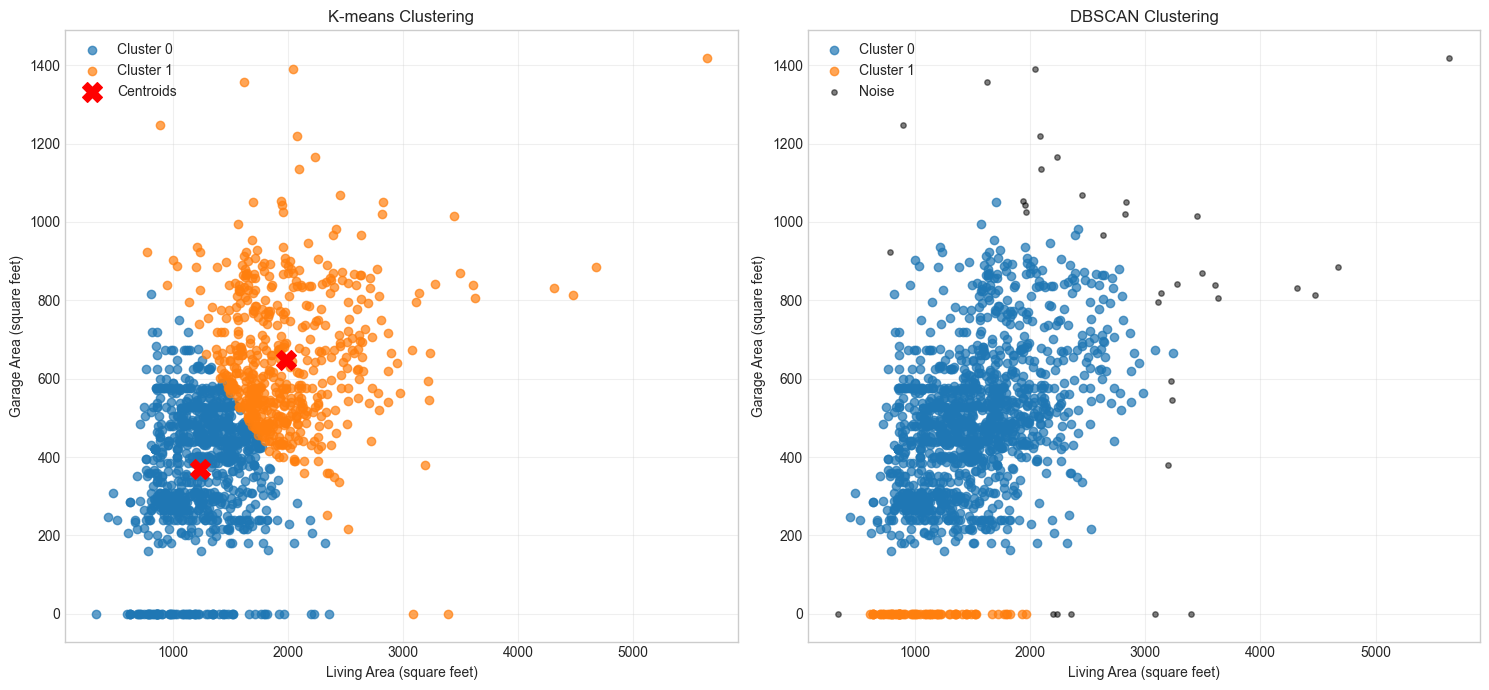

In [17]:
plt.figure(figsize=(15, 7))

# K-means plot
plt.subplot(1, 2, 1)
for i in range(optimal_k):
    cluster_data = X_kmeans[X_kmeans['Cluster'] == i]
    plt.scatter(cluster_data['GrLivArea'], cluster_data['GarageArea'], 
                label=f'Cluster {i}', alpha=0.7)

# Add centroids
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, marker='X', c='red', label='Centroids')
plt.title('K-means Clustering')
plt.xlabel('Living Area (square feet)')
plt.ylabel('Garage Area (square feet)')
plt.legend()
plt.grid(True, alpha=0.3)

# DBSCAN plot
plt.subplot(1, 2, 2)
# Need to handle noise points differently in DBSCAN
is_noise = X_dbscan['Cluster'] == -1
non_noise = X_dbscan[~is_noise]

# Plot non-noise points with cluster colors
for cluster in np.unique(non_noise['Cluster']):
    cluster_data = non_noise[non_noise['Cluster'] == cluster]
    plt.scatter(cluster_data['GrLivArea'], cluster_data['GarageArea'], 
                label=f'Cluster {cluster}', alpha=0.7)

# Plot noise points in black
plt.scatter(X_dbscan.loc[is_noise, 'GrLivArea'], 
           X_dbscan.loc[is_noise, 'GarageArea'], 
           c='black', s=15, alpha=0.5, label='Noise')

plt.title('DBSCAN Clustering')
plt.xlabel('Living Area (square feet)')
plt.ylabel('Garage Area (square feet)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()